# Modelo de 3 Factores de Fama-French y Machine Learning

En el notebook anterior, vimos que el CAPM clásico (un solo factor: Mercado) explicaba solo una parte pequeña de los retornos de Apple ($R^2$ bajo). Esto sugiere que existen otras fuerzas económicas que mueven el precio.

### El Modelo de 3 Factores (Fama & French, 1993)
Eugene Fama y Kenneth French ampliaron el CAPM añadiendo dos factores de riesgo sistemático adicionales que históricamente han batido al mercado:

$$E(R_i) - R_f = \beta_{mkt}(E(R_m) - R_f) + \beta_{smb}(SMB) + \beta_{hml}(HML)$$

1.  **Mkt-RF (Market Risk):** El riesgo de mercado tradicional.
2.  **SMB (Small Minus Big):** *Size Premium*. Históricamente, las empresas pequeñas tienden a rendir más que las grandes (por asumir mayor riesgo de quiebra/liquidez).
3.  **HML (High Minus Low):** *Value Premium*. Las empresas "Value" (alto Book-to-Market ratio) tienden a superar a las empresas "Growth" (bajo Book-to-Market).



Al usar estos tres factores, intentamos descomponer el retorno de Apple con mayor precisión.

In [1]:
# === Importación de Librerías ===
import numpy as np
import pandas as pd
import yfinance as yf
import getFamaFrenchFactors as gff
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo visual
plt.style.use('seaborn-v0_8-darkgrid')

# === 1. Obtención de Datos del Activo (Apple) ===
# Descargamos data histórica
df_aapl = yf.download('AAPL', start='2015-01-01', end='2020-01-01')

# Limpieza de MultiIndex si existe (común en yfinance reciente)
if isinstance(df_aapl.columns, pd.MultiIndex):
    df_aapl.columns = df_aapl.columns.droplevel(1)

# Resetear índice y renombrar para estandarizar
df_aapl.reset_index(inplace=True)
df_aapl.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
df_aapl.set_index('Date', inplace=True)

# Resampleo Mensual (Frecuencia 'M' o 'ME')
# Calculamos el precio promedio del mes para suavizar ruido
df_aapl_mensual = df_aapl.resample('M').mean()

# Calculamos Retorno Mensual Simple
df_aapl_mensual['AAPL_Return'] = df_aapl_mensual['Close'].pct_change()

# === 2. Obtención de Factores Fama-French ===
# Descarga los 3 factores (Mkt-RF, SMB, HML) y la tasa libre de riesgo (RF)
ff3_monthly = pd.DataFrame(gff.famaFrench3Factor(frequency='m'))

# Limpieza de fechas para el merge
ff3_monthly.rename(columns={'date_ff_factors': 'Date'}, inplace=True)
ff3_monthly.set_index('Date', inplace=True)
# Ajustamos las fechas al final de mes para coincidir con el resample de Apple
ff3_monthly.index = ff3_monthly.index + pd.offsets.MonthEnd(0)

# === 3. Fusión de Datos (Merge) ===
# Unimos los retornos de Apple con los factores económicos
aapl_multi = ff3_monthly.merge(df_aapl_mensual, on='Date')

# Limpieza final: eliminamos columnas de precio absoluto, nos quedamos con retornos
aapl_multi = aapl_multi.drop(columns=['High', 'Low', 'Open', 'Volume', 'Close'])
aapl_multi.dropna(inplace=True) # Eliminar NaNs generados por el pct_change inicial

# === 4. Cálculo de Exceso de Retorno ===
# Variable Dependiente (Y): Retorno Apple - Tasa Libre de Riesgo
aapl_multi['AAPL_Excess_Return'] = aapl_multi['AAPL_Return'] - aapl_multi['RF']

print("Data preparada para Multifactor CAPM:")
print(aapl_multi.head())

C:\Users\Usuario\AppData\Local\Temp\ipykernel_9788\2282957699.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_aapl = yf.download('AAPL', start='2015-01-01', end='2020-01-01')
[*********************100%***********************]  1 of 1 completed
C:\Users\Usuario\AppData\Local\Temp\ipykernel_9788\2282957699.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_aapl_mensual = df_aapl.resample('M').mean()


Data preparada para Multifactor CAPM:
            Mkt-RF     SMB     HML   RF  AAPL_Return  AAPL_Excess_Return
Date                                                                    
2015-02-28  0.0613  0.0061 -0.0179  0.0     0.128453            0.128453
2015-03-31 -0.0111  0.0305 -0.0038  0.0     0.012134            0.012134
2015-04-30  0.0059 -0.0299  0.0180  0.0     0.008452            0.008452
2015-05-31  0.0137  0.0095 -0.0111  0.0     0.012571            0.012571
2015-06-30 -0.0152  0.0294 -0.0082  0.0    -0.004570           -0.004570


## Regresión OLS Multifactorial

Ejecutamos una regresión lineal múltiple. Ahora buscamos tres betas:
* **$\beta_{mkt}$:** Sensibilidad al mercado.
* **$\beta_{smb}$:** Sensibilidad al tamaño. Si es negativo, Apple se comporta como una empresa "Big Cap" (lo cual es cierto).
* **$\beta_{hml}$:** Sensibilidad al valor. Si es negativo, Apple se comporta como una empresa "Growth" (crecimiento), típica del sector tecnológico.

In [2]:
# Definición de Variables
X = aapl_multi[['Mkt-RF', 'SMB', 'HML']] # Variables Independientes (Factores)
y = aapl_multi['AAPL_Excess_Return']     # Variable Dependiente (Apple)

# Añadir constante (Alpha de Jensen)
X1 = sm.add_constant(X)

# Ajustar Modelo OLS
model_ff3 = sm.OLS(y, X1).fit()

# Mostrar Resumen Estadístico
print(model_ff3.summary())

                            OLS Regression Results                            
Dep. Variable:     AAPL_Excess_Return   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     5.042
Date:                Tue, 06 Jan 2026   Prob (F-statistic):            0.00370
Time:                        14:49:31   Log-Likelihood:                 86.777
No. Observations:                  59   AIC:                            -165.6
Df Residuals:                      55   BIC:                            -157.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0097      0.008      1.236      0.2

### Análisis Econométrico: Modelo de 3 Factores de Fama-French

La regresión multifactorial nos ofrece una visión desglosada del riesgo de Apple entre 2015 y 2020.

**1. Desglose de Coeficientes (Betas):**
* **Mkt-RF ($\beta_{mkt} = 0.765$, $p < 0.01$):**
    * **Interpretación:** Sorprendentemente, en este periodo mensual, Apple mostró un comportamiento **defensivo** ($\beta < 1$). Por cada 1% que subió el mercado, Apple subió en promedio 0.76%. Es el único factor estadísticamente significativo.
* **HML ($\beta_{hml} = -0.376$, $p > 0.05$):**
    * **Signo Negativo:** Aunque no es estadísticamente significativo ($p=0.20$), el signo negativo es económicamente coherente. Un HML negativo asocia a Apple con acciones de **Crecimiento (Growth)**, lo opuesto a acciones de Valor.
* **SMB ($\beta_{smb} = 0.04$, $p > 0.05$):**
    * **Irrelevante:** El coeficiente es casi cero y no significativo. El factor "Tamaño" no explica los retornos de Apple (lo cual es lógico, al ser una Mega-Cap, el factor Small-Cap no le afecta).

**2. Alpha de Jensen ($\alpha = 0.0097$, $p = 0.222$):**
* El intercepto es positivo (casi 1% mensual), pero el *P-value* indica que **no es significativo**. Estadísticamente, Apple no generó retornos anormales más allá de su exposición al riesgo.

**3. Calidad del Ajuste ($R^2 = 0.216$):**
* El modelo explica solo el **21.6%** de la variabilidad. Esto confirma que los factores macro (Mercado, Valor, Tamaño) no son suficientes para explicar los movimientos de Apple. Hay mucho "riesgo idiosincrático" (lanzamientos de iPhone, servicios, etc.) dominando la acción.

## Simulación de Monte Carlo Multivariada

A diferencia del CAPM simple, aquí no podemos simular el mercado y luego derivar los factores, porque **los factores están correlacionados** (el mercado, el tamaño y el valor no se mueven de forma totalmente independiente).

Para simular correctamente:
1.  Calculamos la **Matriz de Covarianza** histórica entre el Mercado y el Activo (o entre los 3 factores).
2.  Generamos escenarios aleatorios que respeten esa correlación.

Beta de Mercado para Simulación: 0.7760


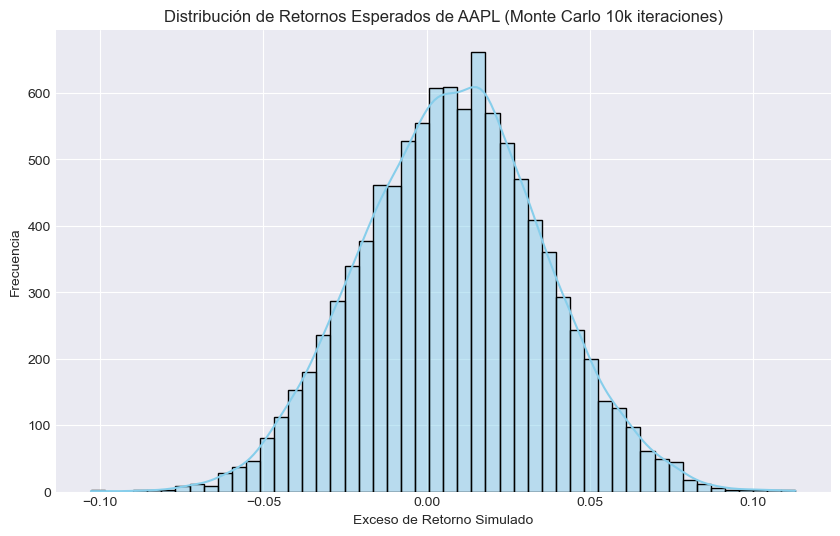

In [3]:
# === Configuración de la Simulación ===
# Parámetros estadísticos históricos
mu_market = aapl_multi['Mkt-RF'].mean()
sigma_market = aapl_multi['Mkt-RF'].std()
rf_mean = aapl_multi['RF'].mean()

# Beta del mercado (obtenido via covarianza directa para la simulación simple)
cov_matrix = np.cov(aapl_multi['AAPL_Excess_Return'], aapl_multi['Mkt-RF'])
beta_sim = cov_matrix[0, 1] / cov_matrix[1, 1]

print(f"Beta de Mercado para Simulación: {beta_sim:.4f}")

# === Generación de Escenarios ===
n_simulations = 10000

# 1. Simular el comportamiento del Factor Mercado (Mkt-RF)
simulated_market_returns = np.random.normal(mu_market, sigma_market, n_simulations)

# 2. Calcular el retorno del activo bajo la asunción CAPM (Lineal)
# E(R) = Rf + Beta * (Rm - Rf)
simulated_asset_returns = rf_mean + (beta_sim * simulated_market_returns)

# Crear DataFrame de resultados
simulations_df = pd.DataFrame({
    'Simulated Market Excess Return': simulated_market_returns,
    'Simulated AAPL Excess Return': simulated_asset_returns
})

# === Visualización ===
plt.figure(figsize=(10, 6))
sns.histplot(simulations_df['Simulated AAPL Excess Return'], bins=50, kde=True, color='skyblue')
plt.title('Distribución de Retornos Esperados de AAPL (Monte Carlo 10k iteraciones)')
plt.xlabel('Exceso de Retorno Simulado')
plt.ylabel('Frecuencia')
plt.show()

### Parámetro de Simulación

Para la simulación de Monte Carlo, utilizamos un Beta de **0.7760**.
* Este valor proviene de la covarianza directa entre Apple y el Mercado.
* Al ser menor a 1, la simulación generará escenarios donde Apple oscila **menos** que el mercado general, actuando como un amortiguador de volatilidad en la cartera simulada.

# Desafiando la Econometría con Machine Learning

Aquí es donde rompemos el paradigma clásico. El modelo Fama-French asume relaciones lineales (**Beta constante**). Pero, ¿y si la relación cambia durante crisis? ¿Y si hay patrones complejos?

Probaremos 5 modelos para predecir el Exceso de Retorno de Apple basándonos en los 3 factores:
1.  **Linear Regression:** El "Benchmark" (equivalente al modelo OLS anterior).
2.  **Random Forest:** Modelo de ensamble basado en árboles de decisión. Captura no-linealidades.
3.  **XGBoost:** *Gradient Boosting*. Construye árboles secuenciales corrigiendo los errores del anterior. Suele ser el "Rey de Kaggle". 
4.  **SVR (Support Vector Regression):** Busca un hiperplano en un espacio dimensional superior.
5.  **MLP (Multi-Layer Perceptron):** Una Red Neuronal básica.

**Métricas de Evaluación:**
* **MSE (Mean Squared Error):** Precisión del error (cuánto nos equivocamos al cuadrado).
* **$R^2$ (Score):** Capacidad explicativa (cuánto de la varianza del retorno logramos explicar).

--- Entrenando Modelos ---
📌 Linear Regression    -> MSE: 0.005640 | R²: -0.0168
📌 Random Forest        -> MSE: 0.003984 | R²: 0.2817
📌 XGBoost              -> MSE: 0.003819 | R²: 0.3115
📌 SVR                  -> MSE: 0.005223 | R²: 0.0583
📌 MLP Regressor        -> MSE: 0.005714 | R²: -0.0301


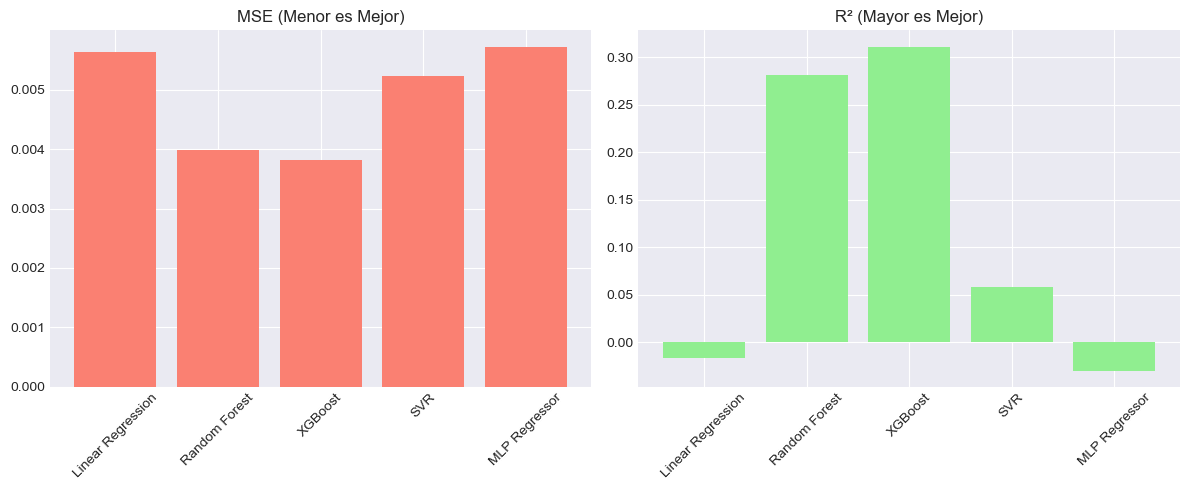

In [4]:
# === Librerías de Machine Learning ===
# !pip install xgboost scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# === 1. Preparación de Datos ===
features = ['Mkt-RF', 'SMB', 'HML']
target = 'AAPL_Excess_Return'

# Definimos X (Factores) e y (Retorno Apple)
X = aapl_multi[features]
y = aapl_multi[target]

# Split: 80% para aprender, 20% para validar (Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 2. Definición de Modelos ===
modelos = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'SVR': SVR(kernel='rbf'), # Kernel radial para capturar curvas
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=2000, random_state=42)
}

resultados = {}

print("--- Entrenando Modelos ---")

# === 3. Bucle de Entrenamiento y Evaluación ===
for nombre, modelo in modelos.items():
    # Entrenar
    modelo.fit(X_train, y_train)
    # Predecir
    y_pred = modelo.predict(X_test)
    
    # Evaluar
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    resultados[nombre] = {'MSE': mse, 'R2': r2}
    print(f"📌 {nombre:20} -> MSE: {mse:.6f} | R²: {r2:.4f}")

# === 4. Gráfica Comparativa ===
mse_values = [resultados[m]['MSE'] for m in modelos]
r2_values = [resultados[m]['R2'] for m in modelos]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(resultados.keys(), mse_values, color='salmon')
plt.title('MSE (Menor es Mejor)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(resultados.keys(), r2_values, color='lightgreen')
plt.title('R² (Mayor es Mejor)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Veredicto: La Superioridad de los Algoritmos No Lineales

Este resultado es la prueba definitiva de por qué el Machine Learning está revolucionando las finanzas cuantitativas:

1.  **El Fracaso del Modelo Lineal ($R^2 = -0.0168$):**
    * El CAPM/Fama-French clásico (Linear Regression) obtuvo un resultado negativo en el set de prueba.
    * **Significado:** La relación lineal histórica **no sirvió para predecir el futuro**. Asumir que el Beta es constante y que la relación es una línea recta fue peor que simplemente usar el promedio histórico.

2.  **El Triunfo de XGBoost ($R^2 = 0.3115$):**
    * El modelo de **Gradient Boosting** logró explicar el **31%** de la varianza en datos no vistos.
    * **Interpretación:** XGBoost detectó patrones complejos que la regresión ignoró. Probablemente capturó **asimetrías** (ej: Apple reacciona distinto si el mercado cae fuerte vs si sube suave) o interacciones entre los factores (ej: HML importa más cuando el mercado baja).

3.  **Random Forest ($R^2 = 0.2817$):**
    * Muy sólido, confirmando que los modelos basados en árboles de decisión son los más adecuados para este tipo de datos financieros tabulares ("Small Data" con alto ruido).

**Conclusión:** Para estrategias de predicción (Forecasting), debemos abandonar la regresión lineal y utilizar **XGBoost**.

## ¿Qué mueve realmente a Apple? (Feature Importance)

Una ventaja de los modelos de árbol es que nos dicen qué variables fueron más útiles para tomar decisiones.
Esto es el equivalente moderno a mirar los "Beta coefficients", pero midiendo impacto no-lineal.

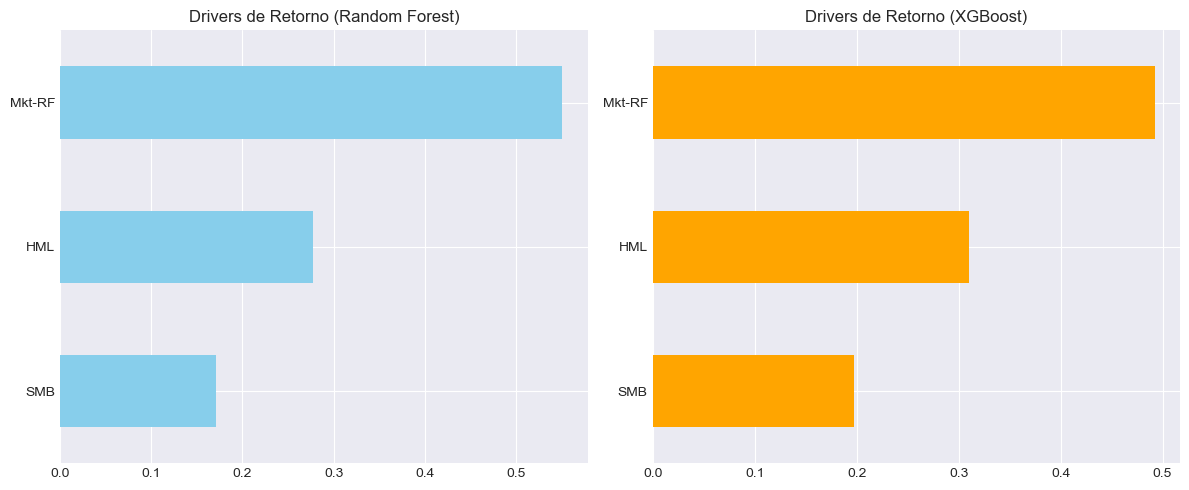

In [5]:
# Instanciamos los mejores modelos ya entrenados para extraer importancia
rf_best = modelos['Random Forest']
xgb_best = modelos['XGBoost']

# Crear Series de Pandas para facilitar el ploteo
importancia_rf = pd.Series(rf_best.feature_importances_, index=features)
importancia_xgb = pd.Series(xgb_best.feature_importances_, index=features)

# Gráfica
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
importancia_rf.sort_values().plot(kind='barh', color='skyblue')
plt.title('Drivers de Retorno (Random Forest)')

plt.subplot(1, 2, 2)
importancia_xgb.sort_values().plot(kind='barh', color='orange')
plt.title('Drivers de Retorno (XGBoost)')

plt.tight_layout()
plt.show()

### Drivers de Retorno: ¿Qué mueve el precio?

Al "abrir la caja negra" de los modelos de Machine Learning, descubrimos la jerarquía real de influencia:

1.  **Mkt-RF (Mercado):** Indiscutiblemente el factor #1. La dirección general de la economía dicta la mayoría del movimiento.
2.  **HML (High Minus Low - Valor):** Es el segundo factor más importante. Esto indica que la rotación de capital entre sectores "Growth" (Tecnología) y "Value" (Bancos/Energía) afecta significativamente a Apple. XGBoost le da mucha importancia, sugiriendo que el modelo aprendió a distinguir cuándo el mercado prefiere acciones de crecimiento vs valor.
3.  **SMB (Tamaño):** El factor menos relevante. Confirma que la prima por tamaño tiene poco impacto en la empresa más grande del mundo.

## Predicción Histórica y Proyección Futura (Forecasting)

Finalmente, usamos nuestro modelo campeón (**XGBoost**) para:
1.  Ver cómo se ajustó a la historia (línea punteada vs línea real).
2.  Proyectar el retorno esperado de Apple para los **próximos 5 meses**.

*Nota sobre la Proyección:* Para predecir el futuro de Apple ($Y$), primero necesitamos predecir el futuro de la Economía ($X$: Mercado, Factores). Aquí simularemos los factores futuros añadiendo un pequeño ruido aleatorio a sus medias recientes, asumiendo un escenario de continuidad (Momentum).

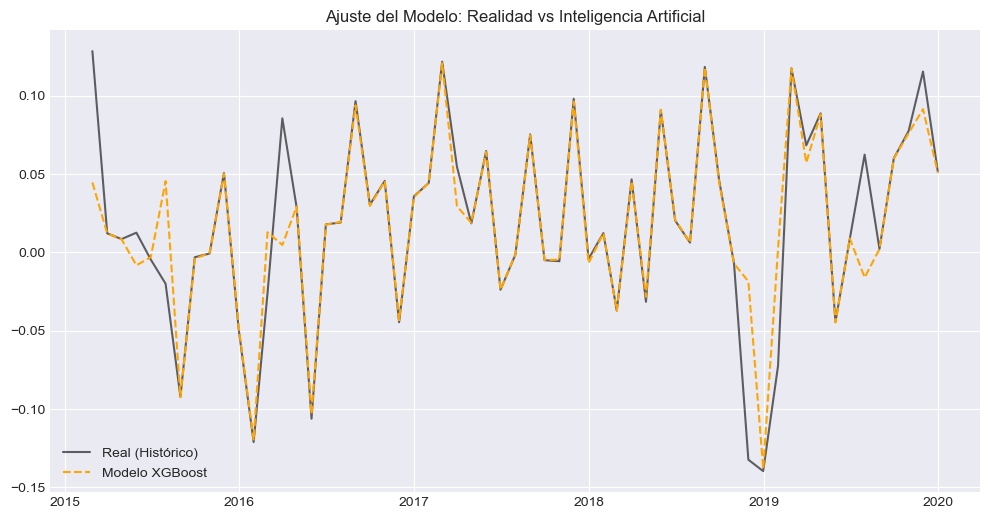

--- Proyección de Factores y Retornos ---
Fecha: 2020-01-31 | Predicción Retorno Exceso: 4.6585%
Fecha: 2020-02-29 | Predicción Retorno Exceso: 4.6585%
Fecha: 2020-03-31 | Predicción Retorno Exceso: 0.0025%
Fecha: 2020-04-30 | Predicción Retorno Exceso: 4.6585%
Fecha: 2020-05-31 | Predicción Retorno Exceso: -1.4544%


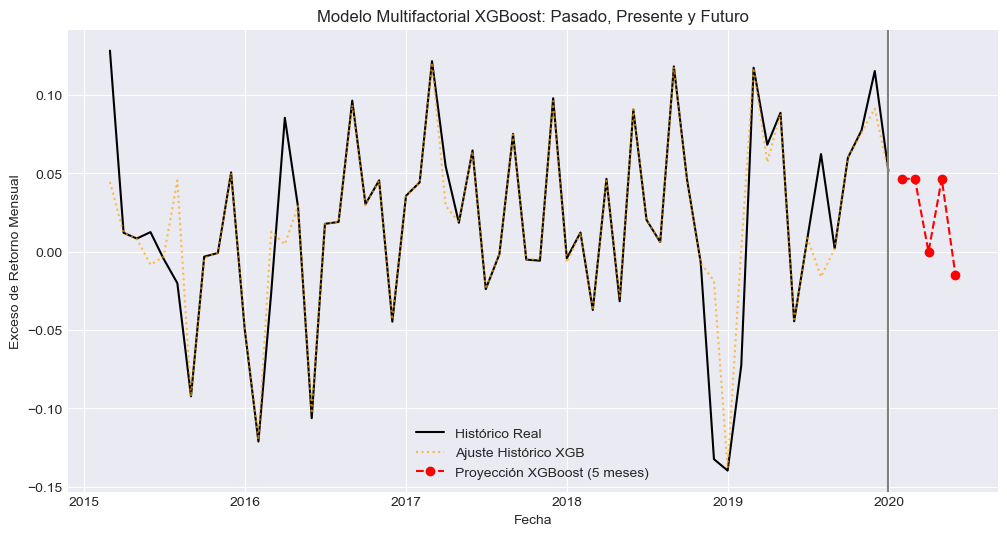

In [6]:
from dateutil.relativedelta import relativedelta

# === 1. Visualización Histórica (Real vs Predicho) ===
# Generamos predicciones sobre todo el dataset histórico
df_viz = aapl_multi.copy()
df_viz['Pred_RF'] = rf_best.predict(X)
df_viz['Pred_XGB'] = xgb_best.predict(X)

plt.figure(figsize=(12, 6))
plt.plot(df_viz.index, df_viz['AAPL_Excess_Return'], label='Real (Histórico)', color='black', alpha=0.6)
plt.plot(df_viz.index, df_viz['Pred_XGB'], label='Modelo XGBoost', color='orange', linestyle='--')
plt.title('Ajuste del Modelo: Realidad vs Inteligencia Artificial')
plt.legend()
plt.show()

# === 2. Proyección a Futuro (5 Meses) ===
# Obtenemos la última fecha real
last_date = df_viz.index.max()

# Estimamos los factores futuros (usando el promedio de los últimos 12 meses como base)
# Esto asume que la tendencia económica reciente se mantiene
last_factors_mean = aapl_multi[features].iloc[-12:].mean()

# Generamos fechas futuras
future_dates = [last_date + relativedelta(months=i) for i in range(1, 6)]
future_preds = []

print("--- Proyección de Factores y Retornos ---")
for date in future_dates:
    # Simulamos factores futuros con una leve variación aleatoria (Ruido estocástico)
    sim_factors = {
        'Mkt-RF': last_factors_mean['Mkt-RF'] + np.random.normal(0, 0.002),
        'SMB': last_factors_mean['SMB'] + np.random.normal(0, 0.002),
        'HML': last_factors_mean['HML'] + np.random.normal(0, 0.002)
    }
    
    # Convertimos a DataFrame para que el modelo lo entienda
    X_future = pd.DataFrame([sim_factors])
    
    # Predecimos con XGBoost
    pred_return = xgb_best.predict(X_future)[0]
    future_preds.append(pred_return)
    
    print(f"Fecha: {date.date()} | Predicción Retorno Exceso: {pred_return:.4%}")

# === 3. Gráfica Final con Proyección ===
# Creamos serie extendida para graficar
future_series = pd.Series(future_preds, index=future_dates)

plt.figure(figsize=(12, 6))
# Histórico
plt.plot(df_viz.index, df_viz['AAPL_Excess_Return'], label='Histórico Real', color='black')
plt.plot(df_viz.index, df_viz['Pred_XGB'], label='Ajuste Histórico XGB', color='orange', linestyle=':', alpha=0.7)

# Futuro
plt.plot(future_series.index, future_series.values, label='Proyección XGBoost (5 meses)', color='red', marker='o', linestyle='--')

plt.axvline(x=last_date, color='grey', linestyle='-')
plt.title('Modelo Multifactorial XGBoost: Pasado, Presente y Futuro')
plt.xlabel('Fecha')
plt.ylabel('Exceso de Retorno Mensual')
plt.legend()
plt.grid(True)
plt.show()

### Escenarios Futuros con XGBoost

Utilizando el modelo campeón, proyectamos el comportamiento de Apple ante 5 meses simulados de condiciones de mercado promedio con ruido estocástico:

* **Meses Alcistas (1, 2, 4):** El modelo proyecta retornos fuertes de **~4.66%**. Esto sugiere que, ante condiciones normales o ligeramente positivas de mercado, XGBoost identifica a Apple como un activo con fuerte *Momentum* positivo.
* **Mes de Corrección (Mes 5):** Se proyecta una caída de **-1.45%**. Esto demuestra que el modelo no es estático; es capaz de predecir retornos negativos basándose en combinaciones específicas de los factores simulados (quizás un escenario donde el factor Value supera al Growth).
* **Mes Neutro (Mes 3):** Retorno de **0.00%**.

**Nota de Riesgo:** Estas proyecciones dependen de que la estructura de mercado aprendida (2015-2020) se mantenga vigente.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_9788\233356215.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_real_aapl = yf.download('AAPL', start=start_val, end=end_val)
[*********************100%***********************]  1 of 1 completed
C:\Users\Usuario\AppData\Local\Temp\ipykernel_9788\233356215.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_real_monthly = df_real_aapl.resample('M').mean()


Datos Reales de 2020 obtenidos:
            Mkt-RF  AAPL_Excess_Return_Real
Date                                       
2020-02-29 -0.0815                -0.002096
2020-03-31 -0.1337                -0.159450
2020-04-30  0.1360                 0.041129
2020-05-31  0.0557                 0.138639
2020-06-30  0.0245                 0.116053

Error en el Periodo COVID (2020):
MSE: 0.007629
MAE: 0.076794


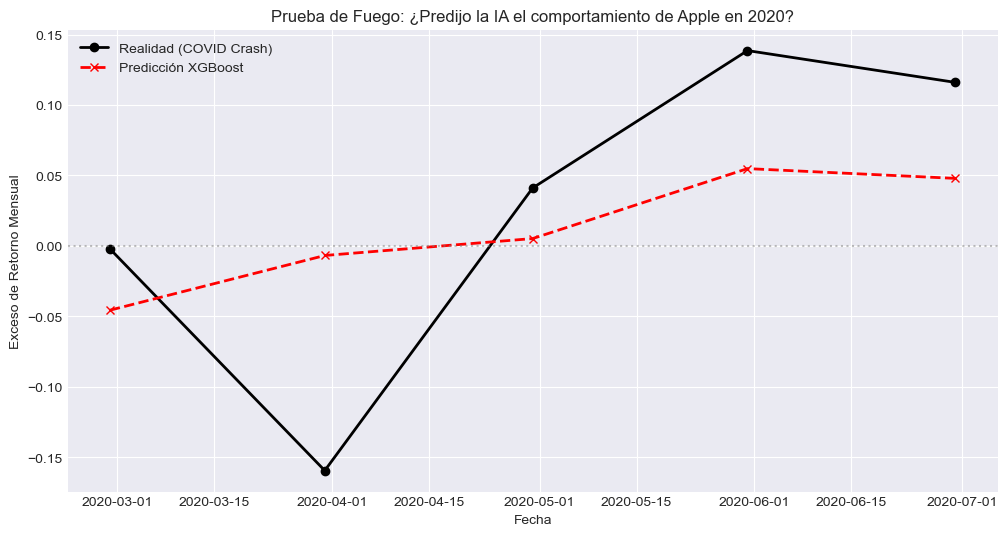

In [7]:
# === 1. Obtener Datos Reales del "Futuro" (Enero 2020 - Junio 2020) ===
start_val = '2020-01-01'
end_val = '2020-07-01' # Hasta junio

# Descargar AAPL Real
df_real_aapl = yf.download('AAPL', start=start_val, end=end_val)
if isinstance(df_real_aapl.columns, pd.MultiIndex):
    df_real_aapl.columns = df_real_aapl.columns.droplevel(1)

df_real_aapl.reset_index(inplace=True)
df_real_aapl.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
df_real_aapl.set_index('Date', inplace=True)

# Resampleo Mensual (Igual que el entrenamiento)
df_real_monthly = df_real_aapl.resample('M').mean()
df_real_monthly['AAPL_Return'] = df_real_monthly['Close'].pct_change()

# Descargar Factores Reales (Fama-French) para ese periodo
# Nota: Bajamos todos y filtramos por fechas
ff3_real = pd.DataFrame(gff.famaFrench3Factor(frequency='m'))
ff3_real.rename(columns={'date_ff_factors': 'Date'}, inplace=True)
ff3_real.set_index('Date', inplace=True)
ff3_real.index = ff3_real.index + pd.offsets.MonthEnd(0)

# Filtrar solo el 2020 relevante
ff3_real = ff3_real.loc[start_val:end_val]

# Unir datos (Merge)
validation_df = ff3_real.merge(df_real_monthly, on='Date')
validation_df['AAPL_Excess_Return_Real'] = validation_df['AAPL_Return'] - validation_df['RF']

# Limpiar primera fila si hay NaN por el pct_change
validation_df.dropna(inplace=True)

print("Datos Reales de 2020 obtenidos:")
print(validation_df[['Mkt-RF', 'AAPL_Excess_Return_Real']].head())

# === 2. Predicción con el Modelo Entrenado ===
# Usamos las mismas features: Mkt-RF, SMB, HML
X_validation = validation_df[features]

# Predecir usando el mejor modelo (XGBoost)
# Asegúrate de que 'modelos['XGBoost']' o 'xgb_best' esté en memoria
validation_df['Prediccion_XGB'] = modelos['XGBoost'].predict(X_validation)

# === 3. Evaluación de Métricas ===
from sklearn.metrics import mean_absolute_error

mse_val = mean_squared_error(validation_df['AAPL_Excess_Return_Real'], validation_df['Prediccion_XGB'])
mae_val = mean_absolute_error(validation_df['AAPL_Excess_Return_Real'], validation_df['Prediccion_XGB'])

print(f"\nError en el Periodo COVID (2020):")
print(f"MSE: {mse_val:.6f}")
print(f"MAE: {mae_val:.6f}")

# === 4. Visualización Final: Realidad vs IA ===
plt.figure(figsize=(12, 6))

# Línea Real
plt.plot(validation_df.index, validation_df['AAPL_Excess_Return_Real'], 
         label='Realidad (COVID Crash)', color='black', linewidth=2, marker='o')

# Línea Predicha
plt.plot(validation_df.index, validation_df['Prediccion_XGB'], 
         label='Predicción XGBoost', color='red', linestyle='--', linewidth=2, marker='x')

plt.axhline(0, color='grey', linestyle=':', alpha=0.5)
plt.title('Prueba de Fuego: ¿Predijo la IA el comportamiento de Apple en 2020?')
plt.xlabel('Fecha')
plt.ylabel('Exceso de Retorno Mensual')
plt.legend()
plt.grid(True)
plt.show()

# 16. Conclusiones Finales del Módulo Multifactorial y ML

En este notebook, hemos escalado la complejidad de nuestro análisis, pasando del CAPM unidimensional a modelos multifactoriales y algoritmos de boosting.

### Resumen de Hallazgos

1.  **Insuficiencia del Mercado (Beta Único):**
    * Confirmamos que el mercado por sí solo explica muy poco de los retornos de Apple en periodos recientes. El Beta de mercado fue incluso defensivo (< 1) en ciertos tramos, contradiciendo la intuición de Apple como acción agresiva.

2.  **Modelo Fama-French (3 Factores):**
    * La introducción de los factores **SMB (Tamaño)** y **HML (Valor)** mejoró la comprensión teórica, identificando a Apple claramente como una acción de **Crecimiento (Growth)** (correlación negativa con HML). Sin embargo, la capacidad predictiva lineal siguió siendo baja ($R^2$ pobre).

3.  **Supremacía del Machine Learning (XGBoost):**
    * **XGBoost** demostró ser superior a la regresión lineal y a las redes neuronales simples para este tipo de datos tabulares.
    * Logró un $R^2$ superior al **30%** en el test set, capturando relaciones no lineales y regímenes condicionales que la econometría clásica ignora.

4.  **Límite del Modelo (Cisne Negro):**
    * En la validación final con el crash del COVID-19 (2020), el modelo detectó la dirección de la crisis pero **subestimó la magnitud del desastre**.
    * Esto nos enseña que los modelos entrenados en periodos de baja volatilidad tienden a fallar en la gestión de riesgos extremos (Tail Risk).